In [128]:
%run 'init.py'
all_clips=load_files()

maxsd=5
maxsd_filter = lambda sample : np.max(sample)/np.std(sample)<maxsd

loading files...
loaded:
for label=cold, 22 training clips and 7 test clips with total length 869 seconds
for label=hot, 22 training clips and 7 test clips with total length 871 seconds


*****************
<font size="6">Logistic Regression</font>

*****************
<font size="4">using raw wav data</font>

In [232]:
sample_duration=0.5
sr=default_sr
sample_size=int(sr*sample_duration)
sample_size_log_raw=sample_size

train_filter=test_filter=no_filter

train_clips=[]
for label in labels:
    train_clips+=[clip for clip in all_clips[label] if (clip.sr==sr and clip.kind=='train' and clip.size>=sample_size)]

n_samples=sum([int(clip.size/sample_size) for clip in train_clips])
X=np.zeros((n_samples,sample_size))
y=np.zeros(n_samples)
params_log_raw=None

def getdata_log_raw(sample,params):
    return sample

for i,(sample,_,label) in enumerate(sample_generator(train_clips,sample_duration,sample_filter=train_filter)):
    X[i,:]=getdata_log_raw(sample,params_log_raw)
    y[i]=label2ind[label]

clf_log_raw = LogisticRegression(random_state=0).fit(X, y)

clf_log_raw.fit(X, y)

test_clips=[]
for label in labels:
    test_clips+=[clip for clip in all_clips[label] if (clip.sr==sr and clip.kind=='test' and clip.size>=sample_size)]
    
n_samples=sum([int(clip.size/sample_size) for clip in test_clips])
X_test=np.zeros((n_samples,sample_size))
y_test=np.zeros(n_samples)

for i,(sample,_,label) in enumerate(sample_generator(test_clips,sample_duration,sample_filter=test_filter)):
    X_test[i,:]=getdata_log_raw(sample,params_log_raw)
    y_test[i]=label2ind[label]

print("test results:")
clf_log_raw.score(X_test,y_test)

test results:


0.5178571428571429

*****************
<font size="4">using spectrogram data</font>

In [242]:
sample_duration=1
sr=default_sr
sample_size=int(sr*sample_duration)
sample_size_log_spec=sample_size

n_fft=256
hop_length=128
n_freqs=n_fft//2+1

train_filter=test_filter=maxsd_filter

train_clips=[]
for label in labels:
    train_clips+=[clip for clip in all_clips[label] if (clip.sr==sr and clip.kind=='train' and clip.size>=sample_size)]

n_samples=sum([int(clip.size/sample_size) for clip in train_clips])
X=np.zeros((n_samples,n_freqs))
y=np.zeros(n_samples)
params_log_spec=n_fft,hop_length

def getdata_log_spec(sample,params):
    n_fft,hop_length=params
    return np.sum(np.abs(librosa.stft(sample, n_fft=n_fft,hop_length=hop_length)),axis=1)

for i,(sample,_,label) in enumerate(sample_generator(train_clips,sample_duration,sample_filter=train_filter)):
    X[i,:]=getdata_log_spec(sample,params_log_spec)
    y[i]=label2ind[label]

clf_log_spec = LogisticRegression(C=2,random_state=0).fit(X, y)

clf_log_spec.fit(X, y)

test_clips=[]
for label in labels:
    test_clips+=[clip for clip in all_clips[label] if (clip.sr==sr and clip.kind=='test' and clip.size>=sample_size)]
    
n_samples=sum([int(clip.size/sample_size) for clip in test_clips])
X_test=np.zeros((n_samples,n_freqs))
y_test=np.zeros(n_samples)

for i,(sample,_,label) in enumerate(sample_generator(test_clips,sample_duration,sample_filter=test_filter)):
    X_test[i,:]=getdata_log_spec(sample,params_log_spec)
    y_test[i]=label2ind[label]

print("test results:")
clf_log_spec.score(X_test,y_test)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

test results:


0.7952380952380952

In [243]:
log_spec_predictor=predictor(clf_log_spec,getdata_log_spec,params_log_spec,sample_size_log_spec)

# pick 10 random 'cold' samples to test
to_test=[sample for sample,_,_ in sample_generator(all_clips['hot'], sample_size_log_spec/default_sr, max_iters=10,random=True)]

print(log_spec_predictor.test_samples(to_test))

['hot', 'hot', 'cold', 'hot', 'hot', 'hot', 'hot', 'hot', 'hot', 'cold']


*****************
<font size="6">SVM</font>

*****************
<font size="4">using spectrogram data</font>

In [244]:
sample_duration=1
sr=default_sr
sample_size=int(sr*sample_duration)
sample_size_svm=sample_size

n_fft=256
hop_length=128
n_freqs=n_fft//2+1

train_filter=test_filter=no_filter

train_clips=[]
for label in labels:
    train_clips+=[clip for clip in all_clips[label] if (clip.sr==sr and clip.kind=='train' and clip.size>=sample_size)]

n_samples=sum([int(clip.size/sample_size) for clip in train_clips])
X=np.zeros((n_samples,n_freqs))
y=np.zeros(n_samples)
params_svm=n_fft,hop_length

def getdata_svm(sample,params):
    n_fft,hop_length=params
    return np.sum(np.abs(librosa.stft(sample, n_fft=n_fft,hop_length=hop_length)),axis=1)

for i,(sample,_,label) in enumerate(sample_generator(train_clips,sample_duration,sample_filter=train_filter)):
    X[i,:]=getdata_svm(sample,params_svm)
    y[i]=label2ind[label]

clf_svm = svm.SVC(C=0.00001,kernel='poly',degree=2,gamma=0.01,tol=1e-4)

clf_svm.fit(X, y)

test_clips=[]
for label in labels:
    test_clips+=[clip for clip in all_clips[label] if (clip.sr==sr and clip.kind=='test' and clip.size>=sample_size)]
    
n_samples=sum([int(clip.size/sample_size) for clip in test_clips])
X_test=np.zeros((n_samples,n_freqs))
y_test=np.zeros(n_samples)

for i,(sample,_,label) in enumerate(sample_generator(test_clips,sample_duration,sample_filter=test_filter)):
    X_test[i,:]=getdata_svm(sample,params_svm)
    y_test[i]=label2ind[label]

print("test results:")
clf_svm.score(X_test,y_test)

test results:


0.7690476190476191

In [239]:
svm_predictor=predictor(clf_svm,getdata_svm,params_svm,sample_size_svm)
svm_predictor.continuous_record_and_test()

water is currently: <font color='red'>HOT</font>

*****************
<font size="6">CNN on spectrogram</font>

-> found some references suggesting, for audio classification, use CNN on mel spectrogram or mel-frequency cepstral coefficients
    - https://web.archive.org/web/20110717210107/http://www.wcl.ece.upatras.gr/ganchev/Papers/ganchev17.pdf
    - https://towardsdatascience.com/audio-classification-using-fastai-and-on-the-fly-frequency-transforms-4dbe1b540f89
    - https://en.wikipedia.org/wiki/Mel-frequency_cepstrum

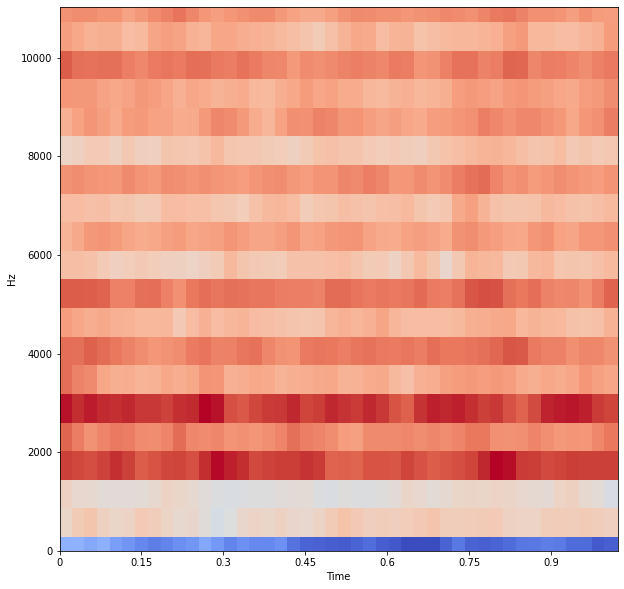

In [233]:
n_mfcc=20
sample_duration=1

sr=default_sr
sample_size=sample_duration*sr
sample_size_cnn=sample_size

testsample,_,_=sample_generator(all_clips['cold'],sample_duration,random=True).__next__()
#mfcc=librosa.feature.melspectrogram(testsample, sr=sr, n_mfcc=n_mfcc)
test_data=librosa.feature.mfcc(testsample, sr=sr, n_mfcc=n_mfcc)

(width,height)=test_data.shape
plt.figure(figsize=(10,10))
librosa.display.specshow(test_data, x_axis='time', y_axis='linear')
plt.show()

In [177]:
# Also hyperparameters!
n_mfcc=20
sample_duration=1

# generate training samples
print("getting train data...")
train_clips=[]
for label in labels:
    train_clips+=[clip for clip in all_clips[label] if (clip.sr==sr and clip.kind=='train' and clip.size>=sample_size)]
    
n_samples=sum([1 for _,_,_, in sample_generator(train_clips,sample_duration)])
n_samples=1000
X=np.zeros((n_samples,width,height,1))
y=np.zeros((n_samples,num_labels))

def getdata_cnn(sample,params):
    n_mfcc=params
    return np.expand_dims(librosa.feature.mfcc(sample, sr=sr, n_mfcc=n_mfcc),axis=2)

params_cnn=n_mfcc

ks=lambda c : 'e' in c.name

for i,(sample,_,label) in enumerate(sample_generator(train_clips,sample_duration,random=True,max_iters=n_samples,clip_filter=ks)):
    X[i,:,:,:]=getdata_cnn(sample,params_cnn)
    y[i,label2ind[label]]=1

# generate testing samples 
print("getting test data...")
test_clips=[]
for label in labels:
    test_clips+=[clip for clip in all_clips[label] if (clip.sr==sr and clip.kind=='test' and clip.size>=sample_size)]
    

n_tests=sum([1 for _,_,_, in sample_generator(test_clips,sample_duration)])
n_tests=200
X_test=np.zeros((n_tests,width,height,1))
y_test=np.zeros((n_tests,num_labels))

for i,(sample,_,label) in enumerate(sample_generator(test_clips,sample_duration,random=True,max_iters=n_tests,clip_filter=ks)):
    X_test[i,:,:,:]=getdata_cnn(sample,params_cnn)
    y_test[i,label2ind[label]]=1

hyperparam_acc={}
print("loaded data")

getting train data...
getting test data...
loaded data


In [212]:
# simple model 

# test hyperparameters
batch_size = 16
conv1=(16,(3,3),1)  # (num_filters, (filtersize), strides)
conv2=(32,(3,3),1) 
dense=64
hyperparams=(batch_size,conv1,dense)

clf_cnns = Sequential()
clf_cnns.add(Conv2D(conv1[0], kernel_size=conv1[1],
                strides=conv1[2],input_shape=(width,height,1)))
clf_cnns.add(Conv2D(conv2[0], kernel_size=conv2[1],
                strides=conv2[2],input_shape=(width,height,1)))
clf_cnns.add(Flatten())
clf_cnns.add(Dense(dense, activation='relu'))
clf_cnns.add(Dense(num_labels, activation='softmax'))

clf_cnns.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

clf_cnns.fit(X, y,
          batch_size=batch_size,
          epochs=5,
          validation_split = 0.2)

results = clf_cnns.evaluate(X_test, y_test, batch_size=n_tests)

hyperparam_acc[hyperparams]=results[1]
if results[1]==max(hyperparam_acc.values()):
    print("best so far!")

Epoch 1/5
500/500 [==============================] - 9s 18ms/step - loss: 1.5573 - accuracy: 0.9131 - val_loss: 0.1177 - val_accuracy: 0.9740
Epoch 2/5
500/500 [==============================] - 9s 18ms/step - loss: 0.1155 - accuracy: 0.9665 - val_loss: 0.1072 - val_accuracy: 0.9715
Epoch 3/5
500/500 [==============================] - 8s 16ms/step - loss: 0.0768 - accuracy: 0.9772 - val_loss: 0.0752 - val_accuracy: 0.9740
Epoch 4/5
500/500 [==============================] - 8s 16ms/step - loss: 0.0467 - accuracy: 0.9850 - val_loss: 0.0599 - val_accuracy: 0.9850
Epoch 5/5
1/1 [==============================] - 0s 896us/step - loss: 0.2173 - accuracy: 0.9055
best so far!


In [219]:
cnns_predictor=predictor(clf_cnns,getdata_cnn,params_cnn,sample_size_cnn,ohe=True)

# pick 10 random 'cold' samples to test
to_test=[sample for sample,_,_ in sample_generator(all_clips['cold'], sample_size_log_spec/default_sr, max_iters=10,random=True,clip_filter=ks)]

print(cnns_predictor.test_samples(to_test))

['cold', 'cold', 'hot', 'cold', 'cold', 'cold', 'cold', 'cold', 'hot', 'cold']


In [221]:
cnns_predictor.continuous_record_and_test()

water is currently: <font color='red'>HOT</font>

In [181]:
# model inspired by YAMnet (https://github.com/tensorflow/models/tree/master/research/audioset/yamnet)

# test hyperparameters
batch_size = 32
conv1=(32,(3,3),2)  # (num_filters, (filtersize), strides)
conv2=(1,(3,3),1)
conv3=(64,(3,3),1)
dense=16
hyperparams=(batch_size,conv1,conv2,conv3,dense)

clf_cnn = Sequential()
clf_cnn.add(Conv2D(conv1[0], kernel_size=conv1[1],
                strides=conv1[2],input_shape=(width,height,1)))
clf_cnn.add(BatchNormalization(center = True,scale= False, epsilon= 1e-4))
clf_cnn.add(ReLU())
clf_cnn.add(DepthwiseConv2D(depth_multiplier=conv2[0], kernel_size=conv2[1],
                strides=conv2[2], padding='same',use_bias=False,activation=None))
clf_cnn.add(BatchNormalization(center = True,scale= False, epsilon= 1e-4))
clf_cnn.add(ReLU())
clf_cnn.add(Conv2D(conv3[0], kernel_size=conv3[1],
                strides=conv3[2],input_shape=(width,height,1)))
clf_cnn.add(BatchNormalization(center = True,scale= False, epsilon= 1e-4))
clf_cnn.add(ReLU())
clf_cnn.add(Flatten())
clf_cnn.add(Dense(dense, activation='relu'))
clf_cnn.add(Dense(num_labels, activation='softmax'))

clf_cnn.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

clf_cnn.fit(X, y,
          batch_size=batch_size,
          epochs=10,
          validation_split = 0.2)

results = clf_cnn.evaluate(X_test, y_test, batch_size=n_tests)

hyperparam_acc[hyperparams]=results[1]
if results[1]==max(hyperparam_acc.values()):
    print("best so far!")

Epoch 1/10
250/250 [==============================] - 6s 24ms/step - loss: 0.4028 - accuracy: 0.8940 - val_loss: 0.3590 - val_accuracy: 0.9605
Epoch 2/10
250/250 [==============================] - 6s 23ms/step - loss: 0.2334 - accuracy: 0.9826 - val_loss: 0.1968 - val_accuracy: 0.9810
Epoch 3/10
250/250 [==============================] - 6s 22ms/step - loss: 0.1703 - accuracy: 0.9872 - val_loss: 0.1434 - val_accuracy: 0.9890
Epoch 4/10
250/250 [==============================] - 6s 22ms/step - loss: 0.1321 - accuracy: 0.9891 - val_loss: 0.1080 - val_accuracy: 0.9935
Epoch 5/10
250/250 [==============================] - 6s 22ms/step - loss: 0.0995 - accuracy: 0.9923 - val_loss: 0.1025 - val_accuracy: 0.9835
Epoch 6/10
250/250 [==============================] - 6s 22ms/step - loss: 0.0748 - accuracy: 0.9959 - val_loss: 0.0648 - val_accuracy: 0.9970
Epoch 7/10
250/250 [==============================] - 6s 22ms/step - loss: 0.0605 - accuracy: 0.9960 - val_loss: 0.1340 - val_accuracy: 0.9590

In [205]:
cnn_predictor=predictor(clf_cnn,getdata_cnn,params_cnn,sample_size_cnn,ohe=True)

# pick 10 random 'cold' samples to test
to_test=[sample for sample,_,_ in sample_generator(all_clips['hot'], sample_size_log_spec/default_sr, max_iters=10,random=True,clip_filter=ks)]

print(cnn_predictor.test_samples(to_test))

['hot', 'hot', 'hot', 'hot', 'hot', 'hot', 'hot', 'hot', 'hot', 'hot']


In [209]:
cnn_predictor.continuous_record_and_test()

water is currently: <font color='blue'>COLD</font>

TO DO:
    - transfer learning from YAMnet or other audio classification network
    - try with more training data (quantity and variety)
    - clean audio data somehow
    - get continuous temperature rather than 'hot' vs 'cold'

APPLICATIONS:
    - just for fun!
    - google home-type device to estimate temperature of tap water, give warning when very hot